In [0]:
from fastai.vision import *
import os
import numpy as npform

Get path

In [2]:
pwd

'/content'

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path_img = '/Users/chingtingtsai/Google Drive/Code/SEM shape/images'
path_lbl = '/Users/chingtingtsai/Google Drive/Code/SEM shape/labels'
get_label=lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

Get Data

In [13]:
fnames = get_image_files(path_img)
fnames[:3]

FileNotFoundError: ignored

In [0]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/Users/chingtingtsai/Google Drive/Code/SEM shape/labels/NanoC1400_P.png'),
 PosixPath('/Users/chingtingtsai/Google Drive/Code/SEM shape/labels/NanoBone800_P.png'),
 PosixPath('/Users/chingtingtsai/Google Drive/Code/SEM shape/labels/NanoV105_P.png')]

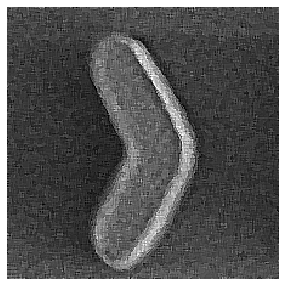

In [0]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl+'/'+x.stem+'_P'+x.suffix

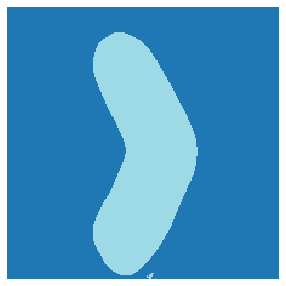

In [0]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [0]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([224, 224]),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=['outer','inter']))

In [0]:
bs=4
data = (src.transform(get_transforms(), tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

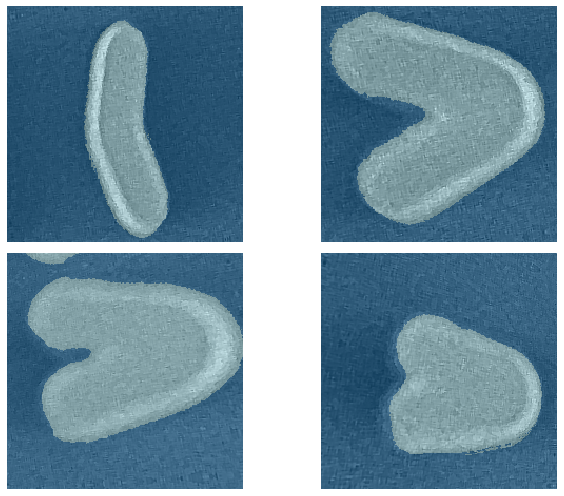

In [0]:
data.show_batch(2, figsize=(10,7))

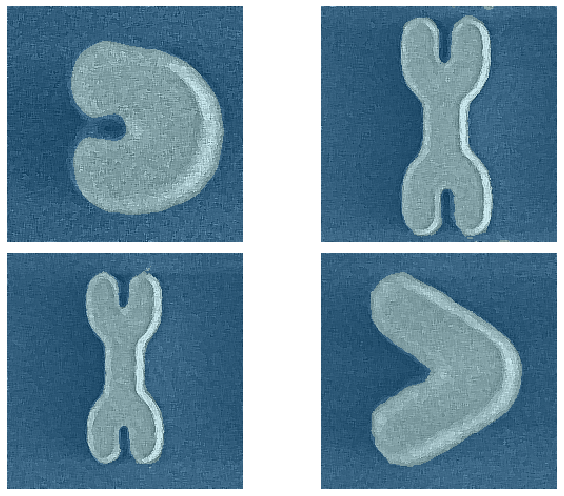

In [0]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

Model

In [0]:
defaults.device = torch.device('cpu')

In [0]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid

In [0]:
wd=1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


RuntimeError: DataLoader worker (pid(s) 5782, 5783, 5784, 5785, 5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793) exited unexpectedly

In [0]:
lr=1e-3

In [0]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.574364,0.508356,0.730457,00:56
1,0.502996,0.268927,0.921624,00:52
2,0.455722,0.246110,0.946201,00:52
3,0.442640,0.323282,0.888648,00:52


RuntimeError: DataLoader worker (pid 5677) is killed by signal: Unknown signal: 0. 

In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (22 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /Users/chingtingtsai/Google Drive/Code/SEM shape/images;

Valid: LabelList (5 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /Users/chingtingtsai/Google Drive/Code/SEM shape/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

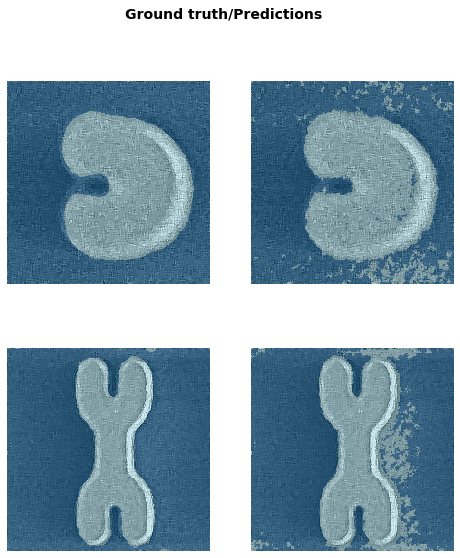

In [0]:
learn.show_results(rows=3, figsize=(8,9))